<a href="https://colab.research.google.com/github/federicasibilla/ITDAFNASS_exam/blob/main/TF_perturbation_haematopoiesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.&nbsp;Introduction and Biological question

## 1.1&nbsp;Biological question

The biological question this algorithm aims to answer is gaining a deep understanding of how transcription factors regulate cell identity, focusing in particular on dynamic biological processes such as differentiation and development. CellOracle makes it indeed possible to consider shifts in cell identity following perturbations of TFs in the context of, for example, natural differentiation, keeping interpretability a priority. In this project, we focus in particular on the process of mouse haematopoiesis to investigate the effects of Gata1 knockout.

<br>
<img src="https://pub.mdpi-res.com/cells/cells-10-00968/article_deploy/html/images/cells-10-00968-g001.png?1618998067" alt="image" width="700" height="500">
<br>



## 1.2&nbsp;Introduction
CellOracle integrates different single-cell technologies to gain biological insight on cell identity regulation. Its notable feature is making it possible to conduct perturbational analysis/pretictions only needing unperturbated experimental data. Not only does it allow for context-specific GRN inference from single-cell data, but also it uses the inferred GRN to in-silico simulate the propagation of a perturbation in TFs. Finally, it combines the resulting cell identity shifts with the underlying 'shifting flows' caused by natural differentiation.



---



This notebook will follow the CellOracle algorithm workflow with the goal of reproducing the main results of the article *Dissecting cell identity via network inference and in silico gene perturbation* regarding mouse haematopoiesis and the effect of Gata1 knockout:


1.   **Construction of base GRN** ('template' GRN):<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1)

  *   use scATAC-seq mouse atlas data to identify potential regulatory interaction regions
  *   scan these for TF motifs and extract interesting TF-target gene connections

2.   **Calculation of context-dependent GRN**:

  *   make an Oracle object integrating base GRN with the scRNA-seq data
  * calculate cluster-specific GRNs
  * analyze inferred GRNs

3.  **Perturbation simulation**:

  * calculate downstream effects of TF perturbation
  * calculate effect of natural dynamic process
  * combine the two effects and analyze the results

<a name="cite_note-1"></a>[<sup>[1]</sup>](#cite_ref-1) Not done in this notebook, a ready-made base GRN is loaded.

# Installing and importing necessary libraries


In [1]:
pip install celloracle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 19.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [2]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

In [3]:
import celloracle as co
co.__version__

2023-06-22 11:47:52,510 - INFO - No config found.
INFO:gimme.config:No config found.
2023-06-22 11:47:52,518 - INFO - Creating new config.
INFO:gimme.config:Creating new config.
2023-06-22 11:47:52,524 - INFO - Using included version of MDmodule.
INFO:gimme.config:Using included version of MDmodule.
2023-06-22 11:47:52,545 - WARNING - MEME not found. To include it you will have to install it.
2023-06-22 11:47:52,578 - WARNING - MEMEW not found. To include it you will have to install it.
2023-06-22 11:47:52,595 - WARNING - DREME not found. To include it you will have to install it.
2023-06-22 11:47:52,603 - WARNING - Weeder not found. To include it you will have to install it.
2023-06-22 11:47:52,617 - WARNING - GADEM not found. To include it you will have to install it.
2023-06-22 11:47:52,623 - INFO - Using included version of MotifSampler.
INFO:gimme.config:Using included version of MotifSampler.
2023-06-22 11:47:52,641 - WARNING - Trawler not found. To include it you will have to in

'0.12.1'

In [4]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]

# 2.&nbsp;Construction of base GNR

In order to propagate a perturbation throughout cell type clusters, one needs to construct a directional network among genes to support TF perturbation propagation. The first skeleton of this network is constructed using single-cell chromatine accessibility data (the *mouse scATAC-seq atlas* in this notebook). These are procesed using Cicero (an R-developed algorithm) to identify co-accessible peaks, by aligning to the reference genome (mm10) and extracting regions that show correlations in accessibility. The identified chromatine regions that correspond to TSS (proximal elements) or are strongly correlated to TSS regions (distal elements) are then scanned for TF binding motifs. These steps lead to the extraction of a list of all candidate regulatory interactions between TFs and target genes in the considered species. This creates the directional base GRN.

<br>
<img src="https://drive.google.com/uc?export=view&id=1--PrBzW2gEAwt5puiNo847vzwxcITriR" alt="image" width="400" height="300">
<br>

Let's briefly summarize how one starts with scATAC data and ends up with the GRN:



*   scATAC data comes in a matrix with cells as columns and chromatine regions on rows: entries contain numeric **values of accessibility**
*   the reference genome is used to assign **genomic coordinates** to the accessibility peaks
*   the correlation of accessibility of different regions among the cells population is used to create (with Cicero) a dataframe with 3 columns: peak1, peak2, **co-accessibility score**
*   the peak data is filtered to only include strong connections with **peaks around transcription starting sites**: this creates a new table where the first column is either a TSS peak or a peak strongly connected to a TSS peak, the second column is the gene associated to the TSS site and the third column is again the numerical value of coacces (1 when the first column was the TSS site chromatine peak itself)
*   motif datasets are used to scan the peak data (converted into DNA sequences) and obtain a connection score for each DNA sequence-motif pair; after only keeping high scores, one finally obtains a **list of TFs** for each target gene, thus the GRN shown above



---

CellOracle comes with built-in base GRNs for 10 commonly studied species, included the one used in this notebook, created from mouse scATAC-seq datasets.


## 2.1&nbsp;Loading base GRN

Given the main goal of this notebook is investigating how unperturbated data can be used to simulate TF perturbations, the scATAC-seq data preprocessing is skipped and the base GRN is loaded form the built-in ones.


In [5]:
# load the base GRN from mous cell atlas dataset
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()

# see the loaded data
base_GRN.head()

Data not found in the local folder. Loading data from github. Data will be saved at /root/celloracle_data/TFinfo_data


  0%|          | 0.00/9.01M [00:00<?, ?B/s]

peak_id gene_short_name  9430076c15rik  Ac002126.6  \
0  chr10_100050979_100052296   4930430F08Rik            0.0         0.0   
1  chr10_101006922_101007748         SNORA17            0.0         0.0   
2  chr10_101144061_101145000          Mgat4c            0.0         0.0   
3    chr10_10148873_10149183   9130014G24Rik            0.0         0.0   
4    chr10_10149425_10149815   9130014G24Rik            0.0         0.0   

   Ac012531.1  Ac226150.2  Afp  Ahr  Ahrr  Aire  ...  Znf784  Znf8  Znf816  \
0         1.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
1         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
2         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
3         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
4         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   

   Znf85  Zscan10  Zscan16  Zscan22  Zscan26  Zscan31  Zscan4  
0    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
1    0.0      0.0      0.0      0.0      0.0      1.0     0.0  
2    0.0      0.0      0.0      0.0      0.0      0.0     1.0  
3    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
4    0.0      0.0      0.0      0.0      0.0      0.0     0.0  

[5 rows x 1095 columns]

In [6]:
base_GRN.shape

(91976, 1095)

The table rows contain target genes and the coulms contain TFs: entries are 1 when the TF's binding motif had a high score in the corresponding target DNA region, 0 otherwise.



# 3.&nbsp;Construction of context-dependent GRN

After the base GRN is loaded, scRNA data is used to identify active connections. While base GRN doesn't necessarily need to be sample specific (and base GRN generated from closely related samples can be used), scRNA data needs to be specific of the process one needs to investigate. This is where CellOracle differs from most other GRN-inference algorithms: the expression data is only used to refine base GRN and account for context-dependent factors, and not to infer directionality of connections. This is specifically what allows the inferred GRN to become the support for perturbation signal propagation.

## 3.1&nbsp;Loading preprocessed scRNA data

The scRNA data is preprocessed to create an anndata object. First, to minimize noise, only variable genes are selected, then the data is log-transformed (though keeping original raw data in a layer), afterwards cells are clustered and embedded in a 2D space, where cell identity and the process trajectories become visible.


---

The data used in this notebook is clustered using Louvain algorithm, which identifies clusters by maximizing connections within communities and differences throughout communities. Dimensionality reduction is then performed using a force-directed-graph embedding strategy, in order to render the clustering in an easy-to-visualize way.

In [6]:
# loading haematopoiesis data
adata = co.data.load_Paul2015_data()
adata

Data not found in the local folder. Loading data from github. Data will be saved at /root/celloracle_data/anndata


  0%|          | 0.00/63.2M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 2671 × 1999
    obs: 'paul15_clusters', 'n_counts_all', 'n_counts', 'louvain', 'cell_type', 'louvain_annot', 'dpt_pseudotime'
    var: 'n_counts'
    uns: 'cell_type_colors', 'diffmap_evals', 'draw_graph', 'iroot', 'louvain', 'louvain_annot_colors', 'louvain_colors', 'louvain_sizes', 'neighbors', 'paga', 'paul15_clusters_colors', 'pca'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_pca'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'connectivities', 'distances'

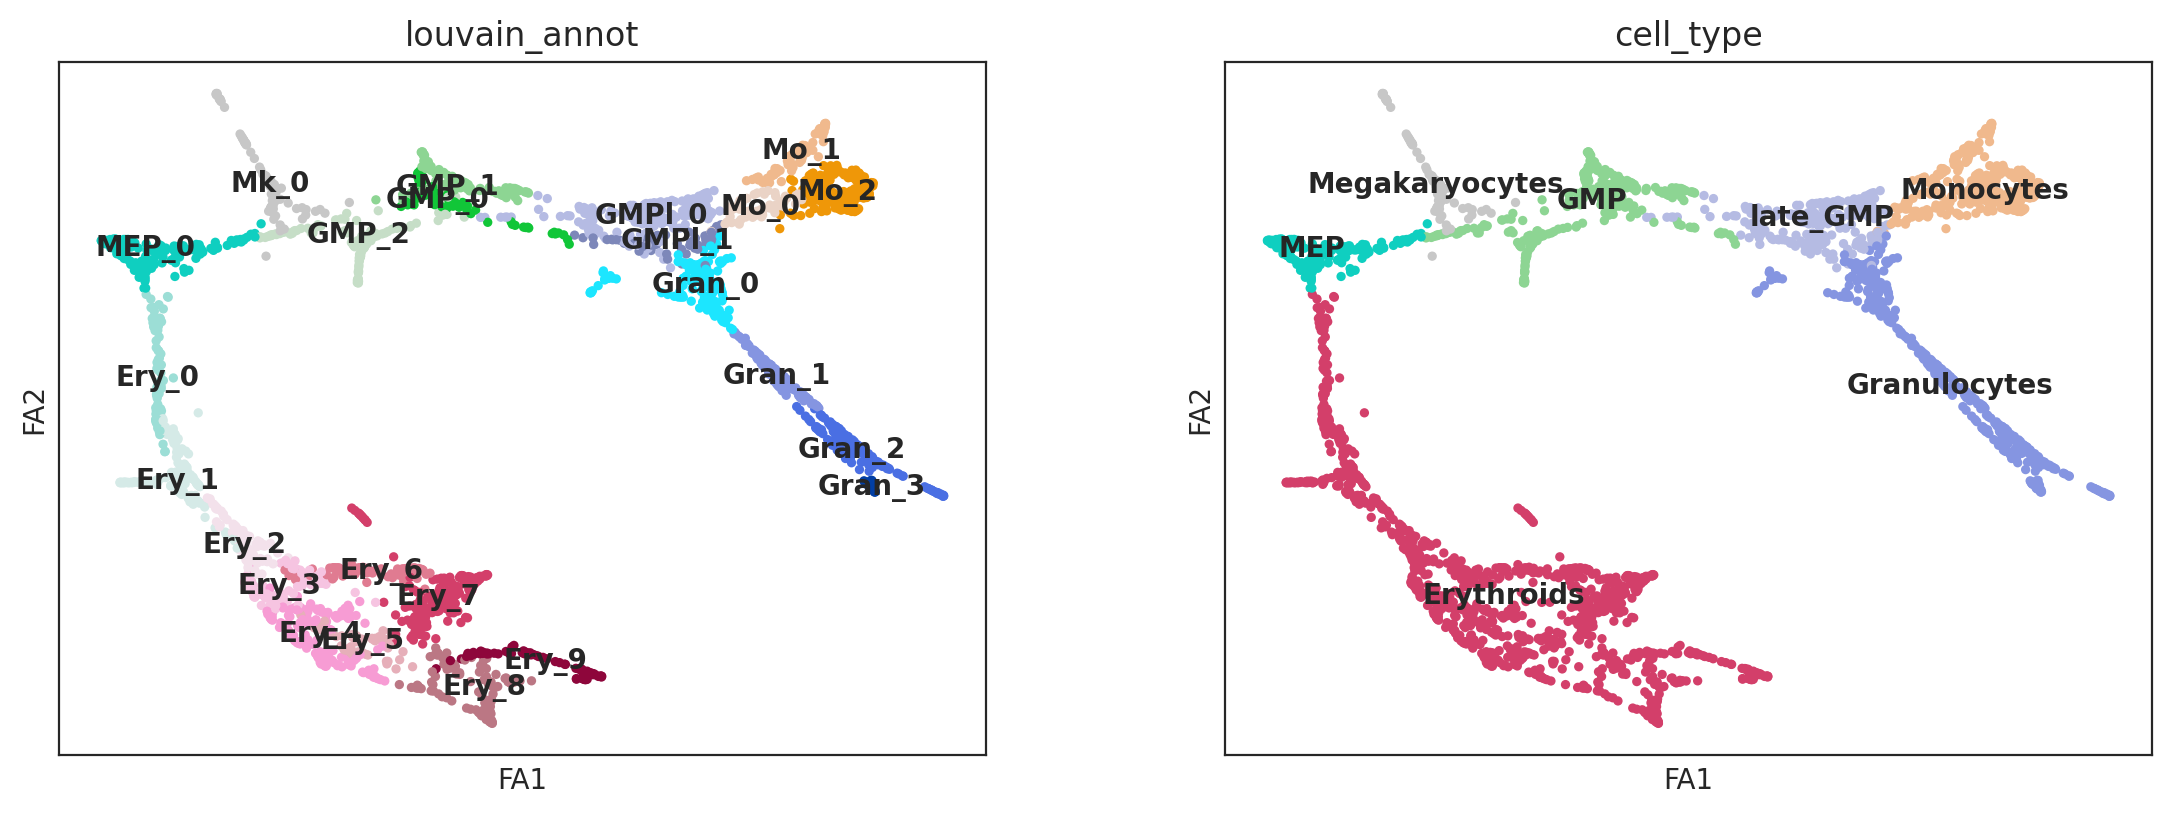

In [7]:
sc.pl.draw_graph(adata, color=['louvain_annot','cell_type'], legend_loc='on data')

Let's check how many cells and gene our object contains.

In [8]:
print(f'Number of cells: {adata.shape[0]}')
print(f'Number of genes: {adata.shape[1]}') # only variable genes were selected

Number of cells: 2671
Number of genes: 1999


## 3.2&nbsp;Integrating base GRN and scRNA data in celloracle object



In [9]:
oracle = co.Oracle()

In [10]:
# choosing unscaled raw data
adata.X = adata.layers['raw_count'].copy()

# create oracle object
oracle.import_anndata_as_raw_count(adata=adata, cluster_column_name='louvain_annot',embedding_name='X_draw_graph_fa')

In [11]:
# load base GRN
oracle.import_TF_data(TF_info_matrix=base_GRN)

Now that the oracle object contains the TF data from base GRN and the scRNA data, we need to perform k-nearest neighbours imputation in order to later be able to visualize the simulated transition results (transition probability vectors will indeed be calculated using similarity with local neighbours, making it necessary to smooth-out data for missing neighbours). K-nn imputation is performed in the PCA space, so we first perform PCA and select the appropriate number of components.

number of components:  45


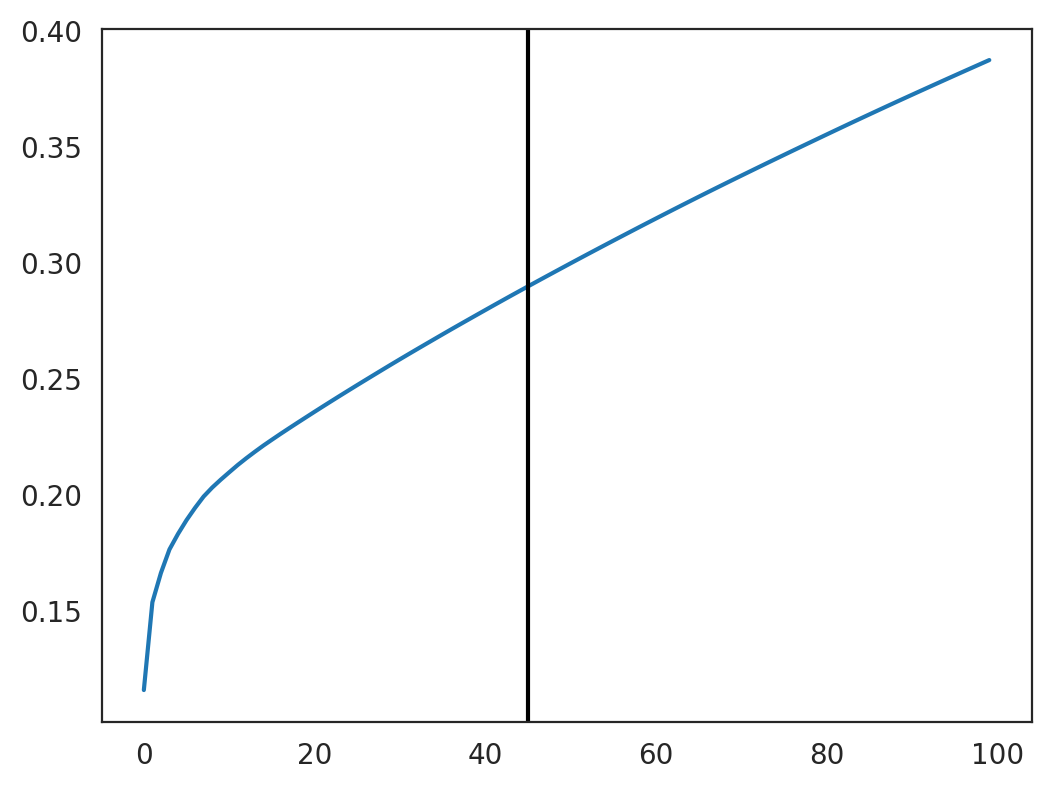

In [21]:
# perform PCA
oracle.perform_PCA()

# select components
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0] #select components where gain between consec. components >0.002
print('number of components: ',n_comps)

plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
plt.axvline(n_comps,c='k')
plt.show()

n_comps = min(n_comps,50) #keep at most 50 components

In [22]:
# automatically select optimal number of neighbours for imputation
n_cell = oracle.adata.shape[0]
k = int(0.025*n_cell)
print(f'selected k: {k}')

selected k: 66


In [23]:
# perform knn imputation
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8, b_maxl=k*4, n_jobs=4)

In [24]:
# final preprocessed oracle object
oracle

Oracle object

Meta data
    celloracle version used for instantiation: 0.12.1
    n_cells: 2671
    n_genes: 1999
    cluster_name: louvain_annot
    dimensional_reduction_name: X_draw_graph_fa
    n_target_genes_in_TFdict: 21256 genes
    n_regulatory_in_TFdict: 1093 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 90 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 1849 genes
    k_for_knn_imputation: 66
Status
    Gene expression matrix: Ready
    BaseGRN: Ready
    PCA calculation: Done
    Knn imputation: Done
    GRN calculation for simulation: Not finished

### Save on drive for following executions
In order to run this script on google colab, the files where loaded from drive, one can however load them from the available files on github.

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
# save oracle object
oracle.to_hdf5('/content/drive/MyDrive/Paul15_data.celloracle.oracle')

In [28]:
# load oracle object (for next executions, file present in github repo)
oracle = co.load_hdf5('/content/drive/MyDrive/Paul15_data.celloracle.oracle')

## 3.3&nbsp;Cluster-specific GRNs calculation

As previously mentioned, because causality (and therefore edges directionality) is inferred from TF information only, expression data can be used to fit linear regularized regression models to each specific cluster, so that gene expression of a target gene $x_{j}$ is determined by expressions of candidate regulatory genes $x_{i}$ in a simple way:

$x_{j}=\sum\limits_{i=0}^{n}b_{ij}x_{i}+c_{j}$

The model applies an L2 regularization (non-informative gaussian prior on the weights distribution) to avoid identifying *false* connections. A bagging ridge model is also available for usage in this step. P-values are calculated on the estimated $b$ weights, to extract robustness of connections.

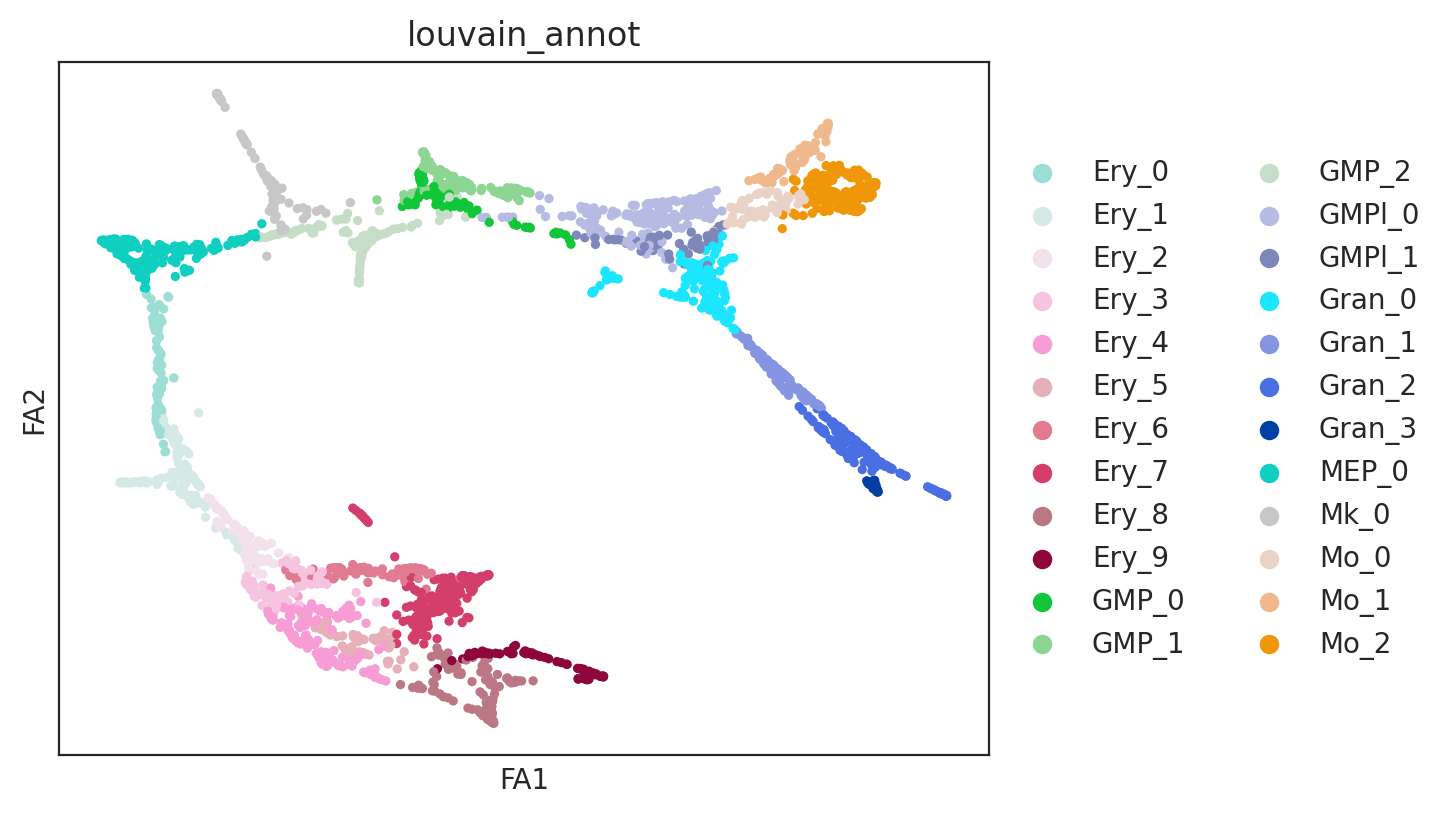

In [30]:
# visualize once again clusters
sc.pl.draw_graph(oracle.adata, color='louvain_annot')

In [31]:
%%time

# calculate GRN for each cluster in the previous picture
links = oracle.get_links(cluster_name_for_GRN_unit='louvain_annot', alpha=10,verbose_level=10)

# this took 2 hours on my computer, but the finished link file is available on the github repo

  0%|          | 0/24 [00:00<?, ?it/s]

Inferring GRN for Ery_0...


  0%|          | 0/1849 [00:00<?, ?it/s]

Inferring GRN for Ery_1...


  0%|          | 0/1849 [00:00<?, ?it/s]

Inferring GRN for Ery_2...


  0%|          | 0/1849 [00:00<?, ?it/s]

Inferring GRN for Ery_3...


  0%|          | 0/1849 [00:00<?, ?it/s]

Inferring GRN for Ery_4...


  0%|          | 0/1849 [00:00<?, ?it/s]

Inferring GRN for Ery_5...


  0%|          | 0/1849 [00:00<?, ?it/s]

Inferring GRN for Ery_6...


  0%|          | 0/1849 [00:00<?, ?it/s]

Inferring GRN for Ery_7...


  0%|          | 0/1849 [00:00<?, ?it/s]

Inferring GRN for Ery_8...


  0%|          | 0/1849 [00:00<?, ?it/s]

Inferring GRN for Ery_9...


  0%|          | 0/1849 [00:00<?, ?it/s]

Inferring GRN for GMP_0...


  0%|          | 0/1849 [00:00<?, ?it/s]

Inferring GRN for GMP_1...


  0%|          | 0/1849 [00:00<?, ?it/s]

Inferring GRN for GMP_2...


  0%|          | 0/1849 [00:00<?, ?it/s]

Inferring GRN for GMPl_0...


  0%|          | 0/1849 [00:00<?, ?it/s]

Inferring GRN for GMPl_1...


  0%|          | 0/1849 [00:00<?, ?it/s]

Inferring GRN for Gran_0...


  0%|          | 0/1849 [00:00<?, ?it/s]

Inferring GRN for Gran_1...


  0%|          | 0/1849 [00:00<?, ?it/s]

Inferring GRN for Gran_2...


  0%|          | 0/1849 [00:00<?, ?it/s]

Inferring GRN for Gran_3...


  0%|          | 0/1849 [00:00<?, ?it/s]

Inferring GRN for MEP_0...


  0%|          | 0/1849 [00:00<?, ?it/s]

Inferring GRN for Mk_0...


  0%|          | 0/1849 [00:00<?, ?it/s]

Inferring GRN for Mo_0...


  0%|          | 0/1849 [00:00<?, ?it/s]

Inferring GRN for Mo_1...


  0%|          | 0/1849 [00:00<?, ?it/s]

Inferring GRN for Mo_2...


  0%|          | 0/1849 [00:00<?, ?it/s]

CPU times: user 50min 30s, sys: 45.8 s, total: 51min 15s
Wall time: 1h 31min 19s


In [32]:
# visualize the GRN of the first cluster as a dictionary
links.links_dict.keys()

dict_keys(['Ery_0', 'Ery_1', 'Ery_2', 'Ery_3', 'Ery_4', 'Ery_5', 'Ery_6', 'Ery_7', 'Ery_8', 'Ery_9', 'GMP_0', 'GMP_1', 'GMP_2', 'GMPl_0', 'GMPl_1', 'Gran_0', 'Gran_1', 'Gran_2', 'Gran_3', 'MEP_0', 'Mk_0', 'Mo_0', 'Mo_1', 'Mo_2'])

In [33]:
links.links_dict['Ery_0']

source         target  coef_mean  coef_abs             p     -logp
0         Chd2  0610007L01Rik  -0.010746  0.010746  1.430644e-06  5.844469
1          Id2  0610007L01Rik  -0.000145  0.000145  9.094647e-01  0.041214
2        Hnf4a  0610007L01Rik   0.002205  0.002205  1.477185e-01  0.830565
3          Myc  0610007L01Rik  -0.008232  0.008232  8.435071e-05  4.073911
4         Fli1  0610007L01Rik   0.000312  0.000312  8.356139e-01  0.077994
...        ...            ...        ...       ...           ...       ...
74898     Irf1            Zyx  -0.012581  0.012581  8.084430e-06  5.092351
74899    Rreb1            Zyx  -0.010638  0.010638  2.129475e-04  3.671727
74900     Egr1            Zyx  -0.002245  0.002245  8.731586e-02  1.058907
74901     Klf6            Zyx   0.019079  0.019079  3.017107e-07  6.520409
74902  Smarcc1            Zyx   0.006276  0.006276  1.399546e-02  1.854013

[74903 rows x 6 columns]

Each cluster's GRN contains source and target genes paires, with correspondent coefficients and p-values. The higher the coefficient (i.e. stronger connection), the lower the p-value (i.e. higher certainty of connection).

## 3.4&nbsp;Network processing

In this step, weak or insignificant connections are filtered out on the basis of p-values and absolute value of edge strength. The threshold here can be decided by the user, we follow the reference and choose the threshold at 2000 (we keep the strongest 2000 edges).

In [47]:
links.filter_links(p=0.001, weight='coef_abs', threshold_number=2000)

The filtering threshold influences the degree distributions of the resulting networks. We now calculate network scores for all the nodes.

In [48]:
# calculate network scores for each gene
links.get_network_score()
links.merged_score.head()

degree_all  degree_centrality_all  degree_in  degree_centrality_in  \
Mycn            45               0.082873          0              0.000000   
Prdx6           11               0.020258         11              0.020258   
Mt1             19               0.034991         19              0.034991   
Ybx1            73               0.134438         10              0.018416   
Anp32b          10               0.018416         10              0.018416   

        degree_out  degree_centrality_out  betweenness_centrality  \
Mycn            45               0.082873                     0.0   
Prdx6            0               0.000000                     0.0   
Mt1              0               0.000000                     0.0   
Ybx1            63               0.116022                  1428.0   
Anp32b           0               0.000000                     0.0   

        eigenvector_centrality cluster  
Mycn                  0.506845   Ery_0  
Prdx6                 0.453841   Ery_0  
Mt1                   0.639691   Ery_0  
Ybx1                  0.525990   Ery_0  
Anp32b                0.238685   Ery_0

In [49]:
# save filtered links
# start from here for next executions (files present in github repo)
links.to_hdf5(file_path='/content/drive/MyDrive/Paul15_data.celloracle.links')
links = co.load_hdf5('/content/drive/MyDrive/Paul15_data.celloracle.links')

## 3.5&nbsp;Network analysis

### Score comparison between clusters

The first analysis one can conduct is comparing the same score in different  clusters. This comparison considers genes that are relevant in both clusters and compares their scores. As an example, we illustrate here the comparison of degree centrality between Ery_0 and GMP_0.

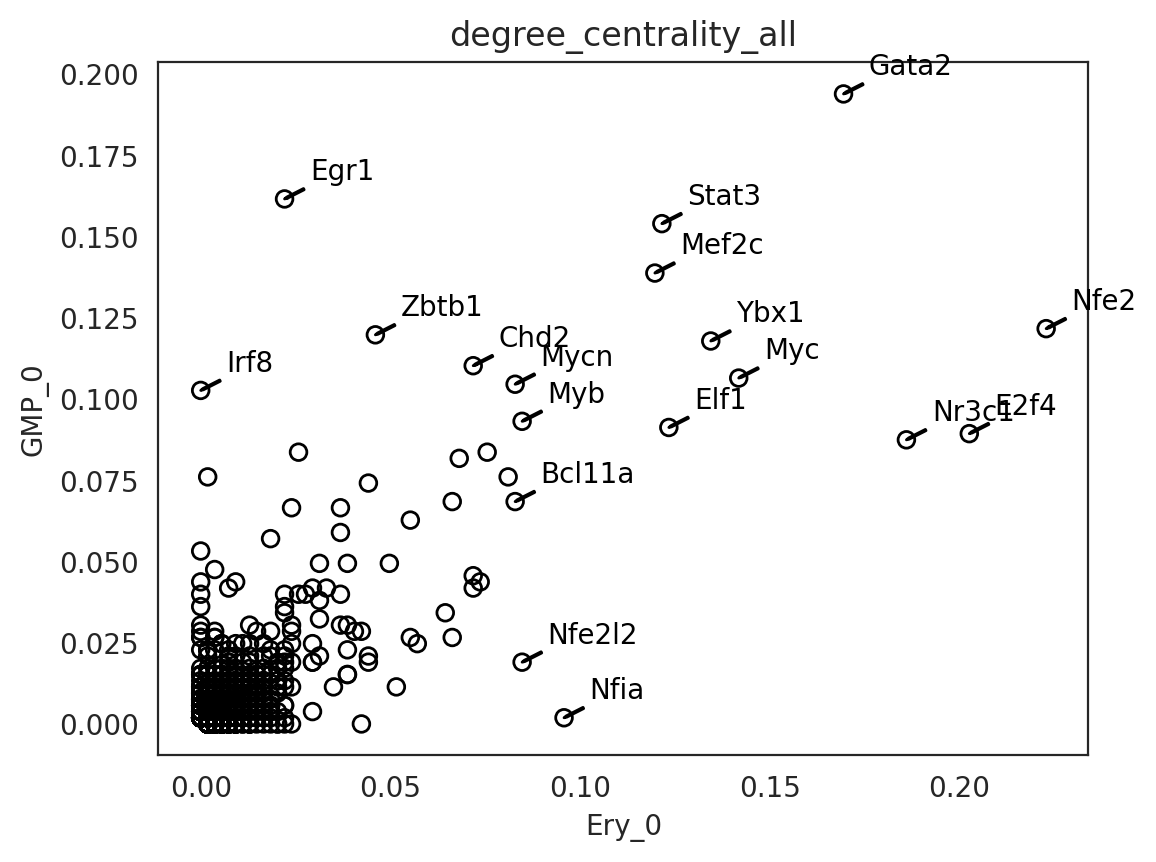

In [41]:
# degree centrality comparison
links.plot_score_comparison_2D(value='degree_centrality_all', cluster1='Ery_0', cluster2='GMP_0', percentile=98)

We see for example that Gata2 has high scores of degree centrality in both Ery_0 and GMP_0, while Egr1 is far more central in GMP_0 than in Ery_0. Such considerations can offer biological insights about the relative importance of genes in different cell types.

### Score dynamics

Since what we are interested in is the dynamic evolution of cells, it is important to consider how scores change during differentiation. Here, for example, we focus on Gata1 (which we will study during the perturbation simulation).

Gata1


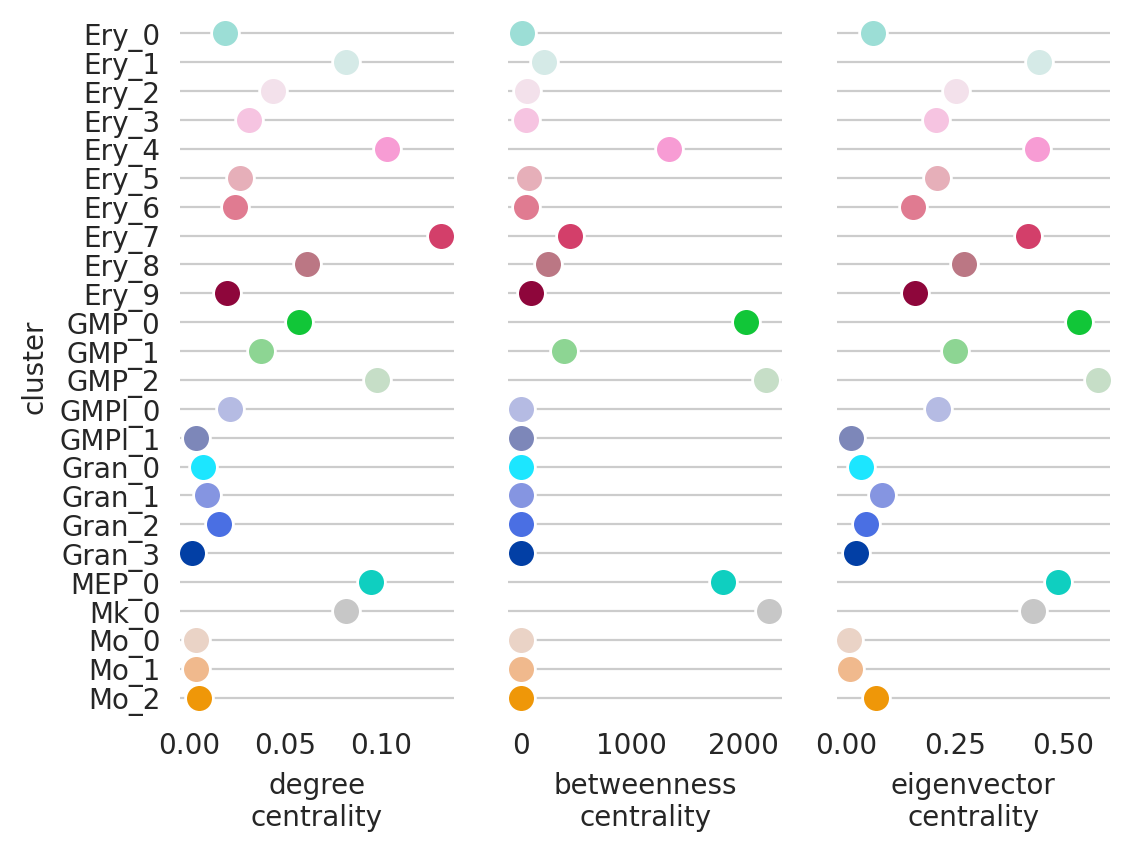

In [42]:
# visualize gata1 scores changes during differentiation (i.e. in different clusters)
links.plot_score_per_cluster(goi='Gata1')

# 4.&nbsp;TF perturbation simulation

The very heart of CellOracle algorithm is the perturbation simulation, with the scope of understanding how TFs regulate cell identity. We focus here on the simulation of Gata1 knockout (because of the available experimental information about Gata1's biological function in differentiation).



*   scRNA data is again processed in a way that can be used by Velocyto's adaptation to the scope of the simulation
*   signal propagation: the linear coefficients $b$ previously inferred are used to propagate the perturbation: $\Delta x_{j}=\sum\limits_{i}b_{ij}\Delta x_{i}$; because of the linearity of the model, chain rule can easily be used to extend the propagation to indirect interactions
*   iteration of the propagation a fixed number of times: the simulated shift vector $\Delta X'=\Delta X_{input}*B$ can then be used as the input perturbation to obtain $\Delta X''=\Delta X'*B$ and so on; default number of iterations is 3
*   the simulated shift if projected in the 2D embedding: a transition probability matrix P is created (using Pearson's correlation coefficient) where entry $p_{ij}$ represents the probability of cell $i$ to adopt cell $j$'s identity
*   $p_{i}$ is converted in a 2D transition vector $V_{i}$ by computing the average, weighted with transition probabilities, of the distance vectors between cell $i$ and neighbour cells $j$: $V_{i}=\sum\limits_{j}p_{ij}d_{ij}$

<br>
<img src="https://drive.google.com/uc?export=view&id=1Vj9O3M2b8u36jUbcaPSm-swo7QgxnIS6" alt="image" width="800" height="200">
<br>
<br>
<img src="https://drive.google.com/uc?export=view&id=1-Ou2fzC6ULrqRbVWK5s4Hl3OoEZedZkz" alt="image" width="800" height="200">
<br>



In [5]:
# load the oracle and link object created in previous steps
from google.colab import drive
drive.mount('/content/drive')

oracle = co.load_hdf5('/content/drive/MyDrive/Paul15_data.celloracle.oracle')
links = co.load_hdf5('/content/drive/MyDrive/Paul15_data.celloracle.links')

Mounted at /content/drive


In [6]:
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10,use_cluster_specific_TFdict=True)

  0%|          | 0/24 [00:00<?, ?it/s]

## 4.1&nbsp;Check current expression and calculate expression after knockout

Here we visualize the expression of Gata1 across clusters befor KO, to then compare it to expression after the perturbation.

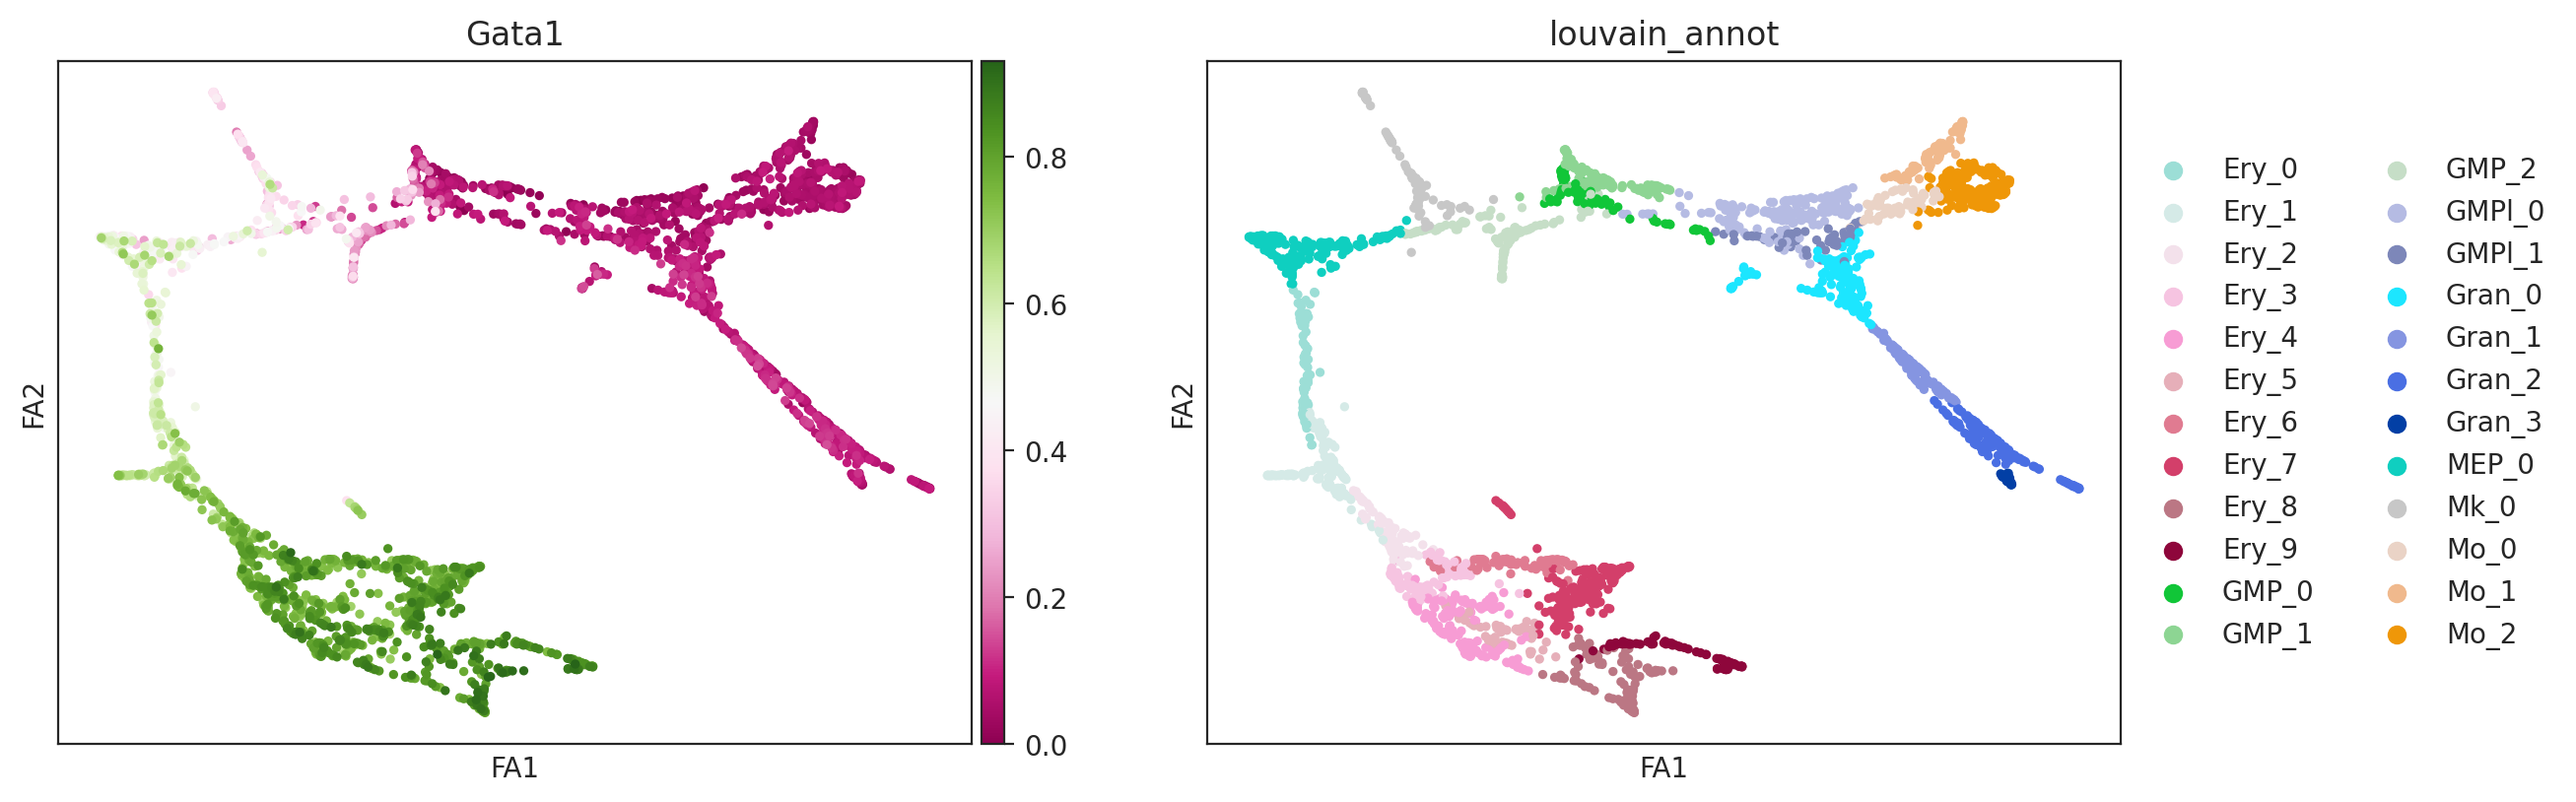

In [7]:
goi = 'Gata1'
sc.pl.draw_graph(oracle.adata, color=[goi, oracle.cluster_column_name], layer='imputed_count',use_raw=False, cmap='PiYG')

In [8]:
# calculate gene expression after the perturbation
oracle.simulate_shift(perturb_condition={goi:0.}, n_propagation=3) # choose the number of iterative perturbation steps

In [9]:
# calculate matrix P
oracle.estimate_transition_prob(n_neighbors=200,knn_random=True,sampled_fraction=1)

# calculate vectors Vi
oracle.calculate_embedding_shift(sigma_corr=0.05)

## 4.2&nbsp;Show directions of cell transitions

In the following plot, each cell is associated to a transition vector $V_{i}$ to visualize transition directions.

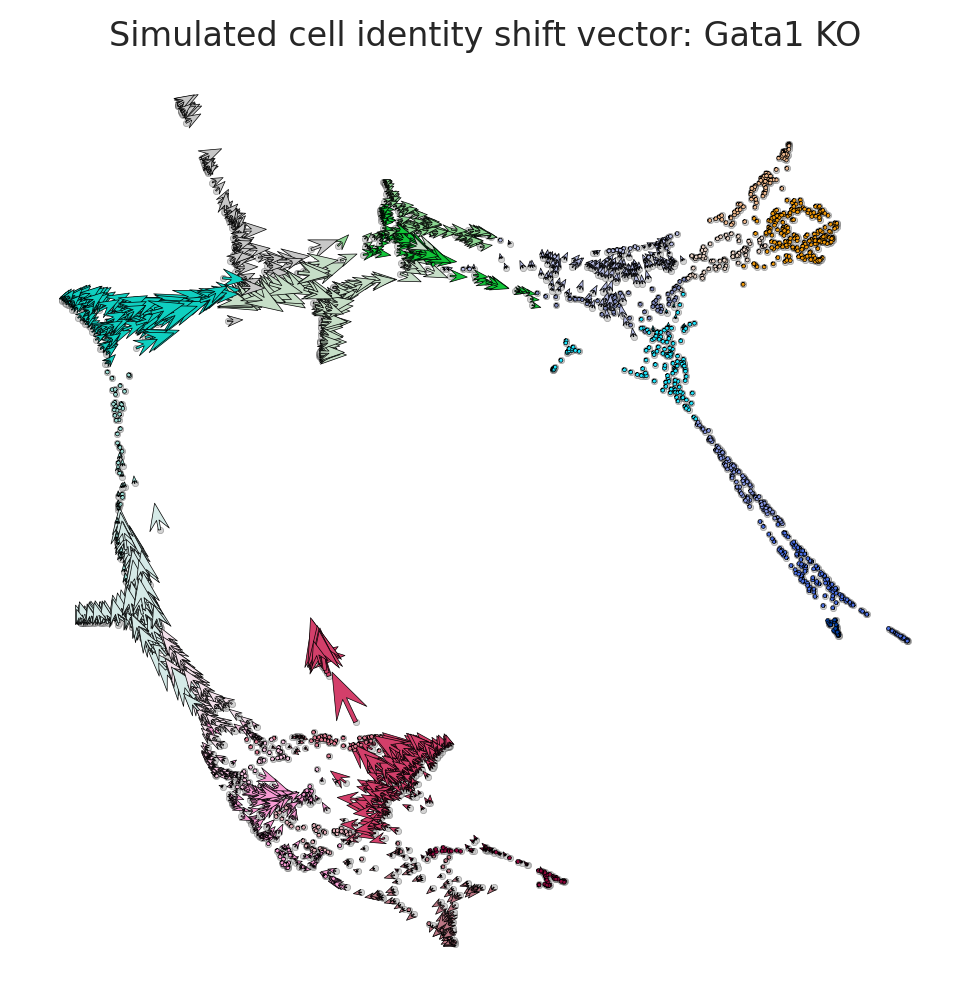

In [12]:
fig, ax = plt.subplots(figsize=[6,6])

scale=25

oracle.plot_quiver(scale=scale, ax=ax)
ax.set_title(f'Simulated cell identity shift vector: {goi} KO')

plt.show()

## 4.3&nbsp;Create vector field

To better interpret the results in cell identity shift, a less fine vector field of transition is needed: at this scope one needs to define a grid (with lower resolution than single cell). A gaussian kernel smoothing is applied to group single-cell vectors into grid-points vectors.

In [13]:
# creating the grid
n_grid = 40
oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200) #associate a mass to each point to only have grid point where cells are

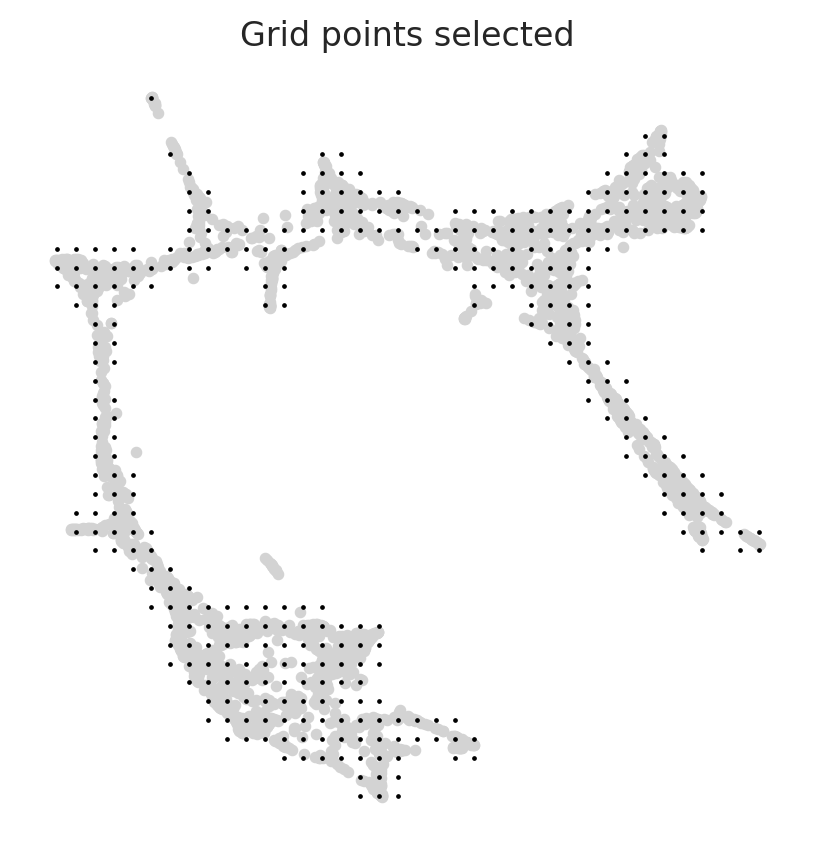

In [14]:
# choose minimum mass to keep the grid point (chosen by running suggest_mass_threshold)
min_mass = 0.01
oracle.calculate_mass_filter(min_mass=min_mass, plot=True)

Text(0.5, 1.0, 'Simulated shift vector field: Gata1 KO')

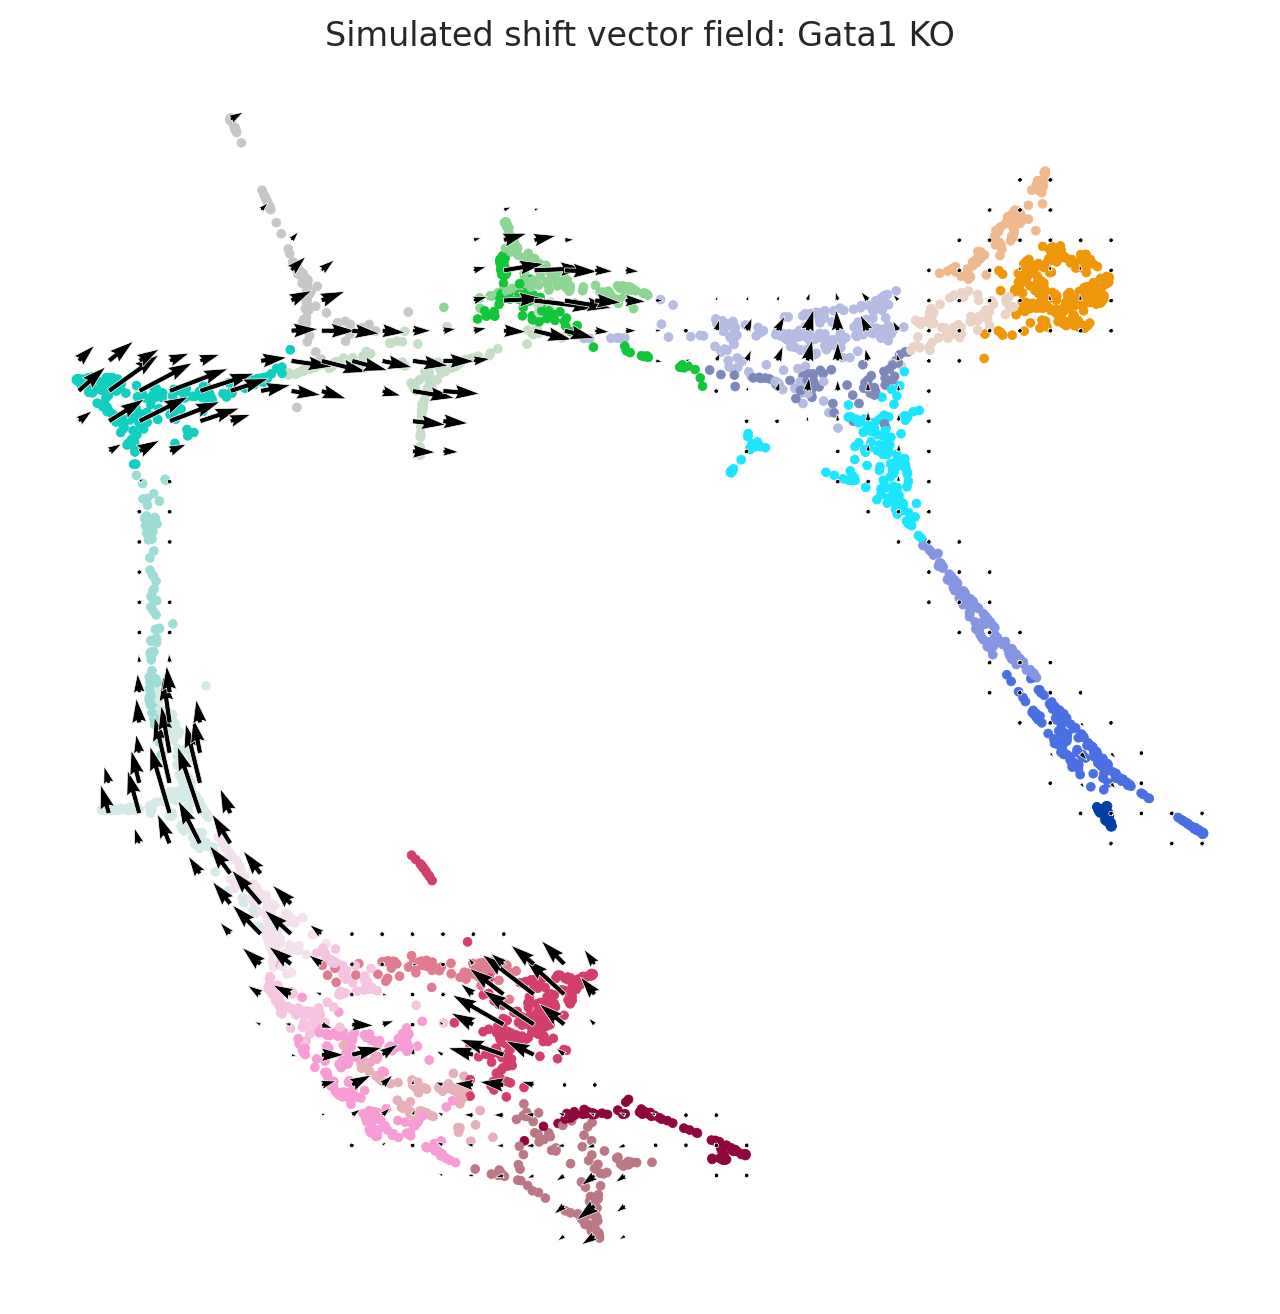

In [17]:
# superimpose it to cluster graph to visualize shifts between cell-types
fi, ax = plt.subplots(figsize=[8,8])

oracle.plot_cluster_whole(ax=ax, s=10)
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax, show_background=False)
ax.set_title(f'Simulated shift vector field: {goi} KO')

# 5.&nbsp;Accounting for the underlying dynamic process

The transition vectors must be considered in the context of differentiation: to do so, we have to quantify similarity between the differentiation vector field and the perturbation simulation vector field. This is done in two steps:


*   differentiation vectors calculations with pseudotime data
*   inner product between the two vector fields

<br>
<img src="https://drive.google.com/uc?export=view&id=1-Uz3R88JdaOY7VWWTumsPZOLbjHdtiuB" alt="image" width="1000" height="200">
<br>



## 5.1&nbsp;Differentiation vectors calculations with pseudotime data

In [18]:
# make new oracle object with pseudotime info
oracle1 = co.data.load_tutorial_oracle_object()

Data not found in the local folder. Loading data from github. Data will be saved at /root/celloracle_data/tutorial_data


  0%|          | 0.00/77.7M [00:00<?, ?B/s]

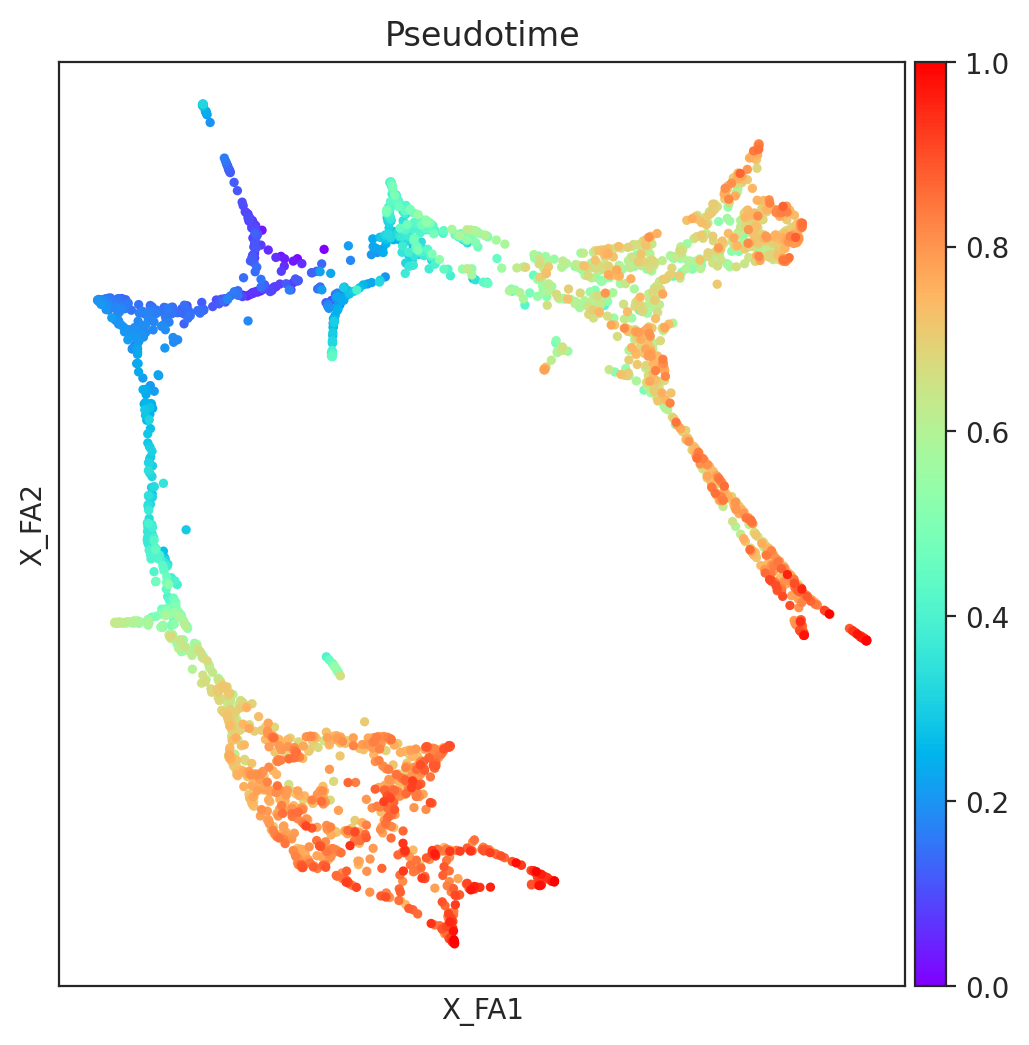

In [19]:
# visualize time trajectories on clusters plot
fig, ax = plt.subplots(figsize=[6,6])

sc.pl.embedding(adata=oracle1.adata, basis=oracle1.embedding_name, ax=ax, cmap='rainbow', color=['Pseudotime'])

In [20]:
# calculate gradient and transfer pseudotime data on the same grid used for the vector field
from celloracle.applications import Gradient_calculator

gradient = Gradient_calculator(oracle_object=oracle1, pseudotime_key='Pseudotime')
gradient.calculate_p_mass(smooth=0.8, n_grid=n_grid,n_neighbors=200)
gradient.calculate_mass_filter(min_mass=min_mass, plot=False)

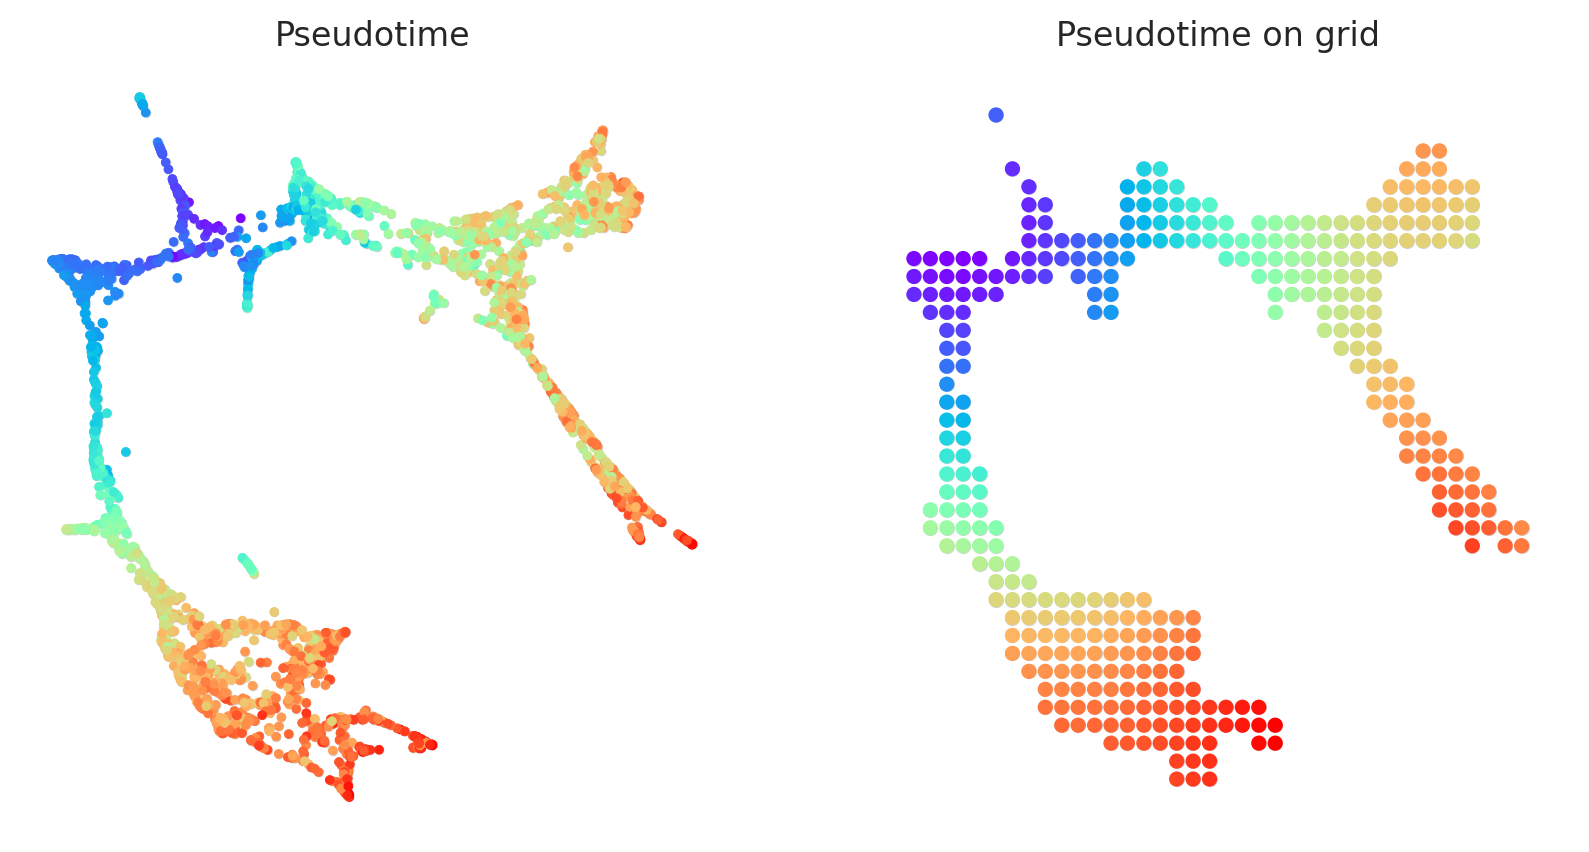

In [21]:
gradient.transfer_data_into_grid(args={'method':'polynomial','n_poly':3}, plot=True)

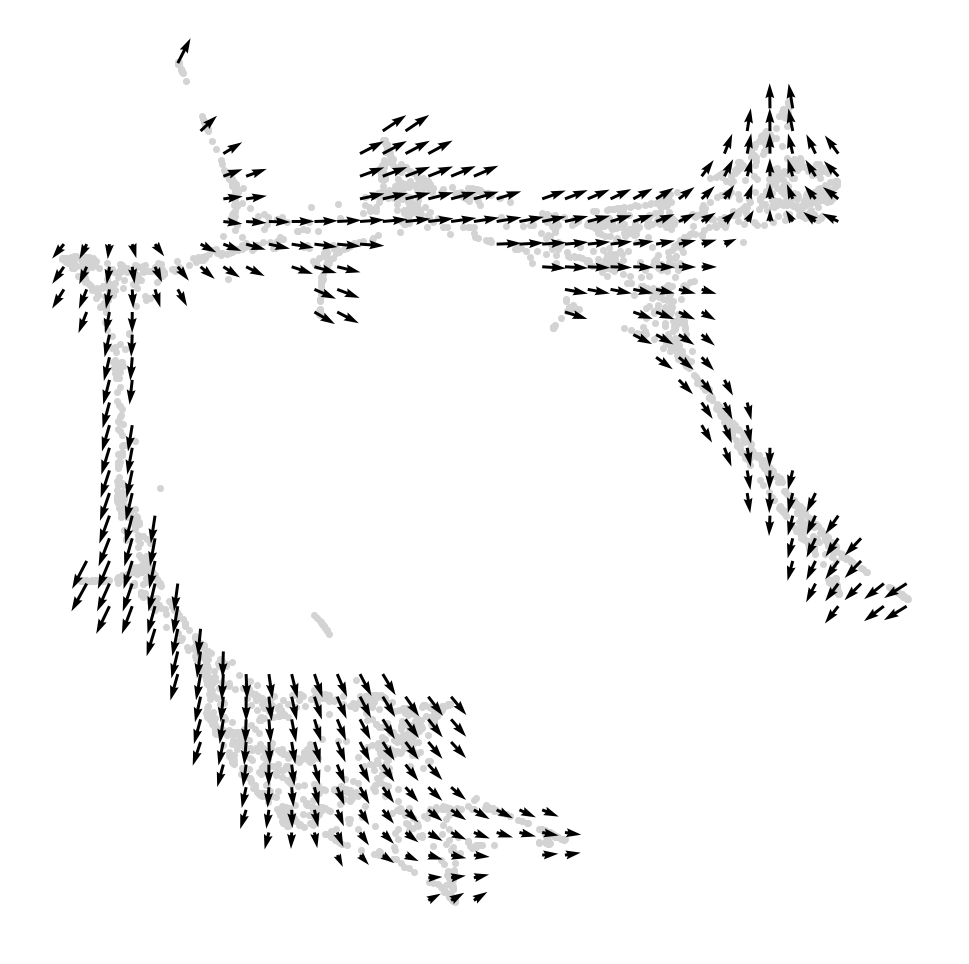

In [22]:
# calculate the vector field due to development flow
gradient.calculate_gradient()

# visualize this vector field
fig,ax = plt.subplots(figsize=[6,6])
gradient.plot_dev_flow_on_grid(scale=40, ax=ax)

## 5.2&nbsp;Combining perturbation shift vector field and development flow: inner product

We are finally able to combine the two vector fields to account for both natural differentiation and the shift in cell identity due to Gata1 KO. This is done by computing the inner product of the two vectors at every grid point.

In [23]:
from celloracle.applications import Oracle_development_module

dev = Oracle_development_module()
dev.load_differentiation_reference_data(gradient_object=gradient)
dev.load_perturb_simulation_data(oracle_object=oracle)

dev.calculate_inner_product()
dev.calculate_digitized_ip(n_bins=10)

Text(0.5, 1.0, 'Perturbation score: Gata1 KO')

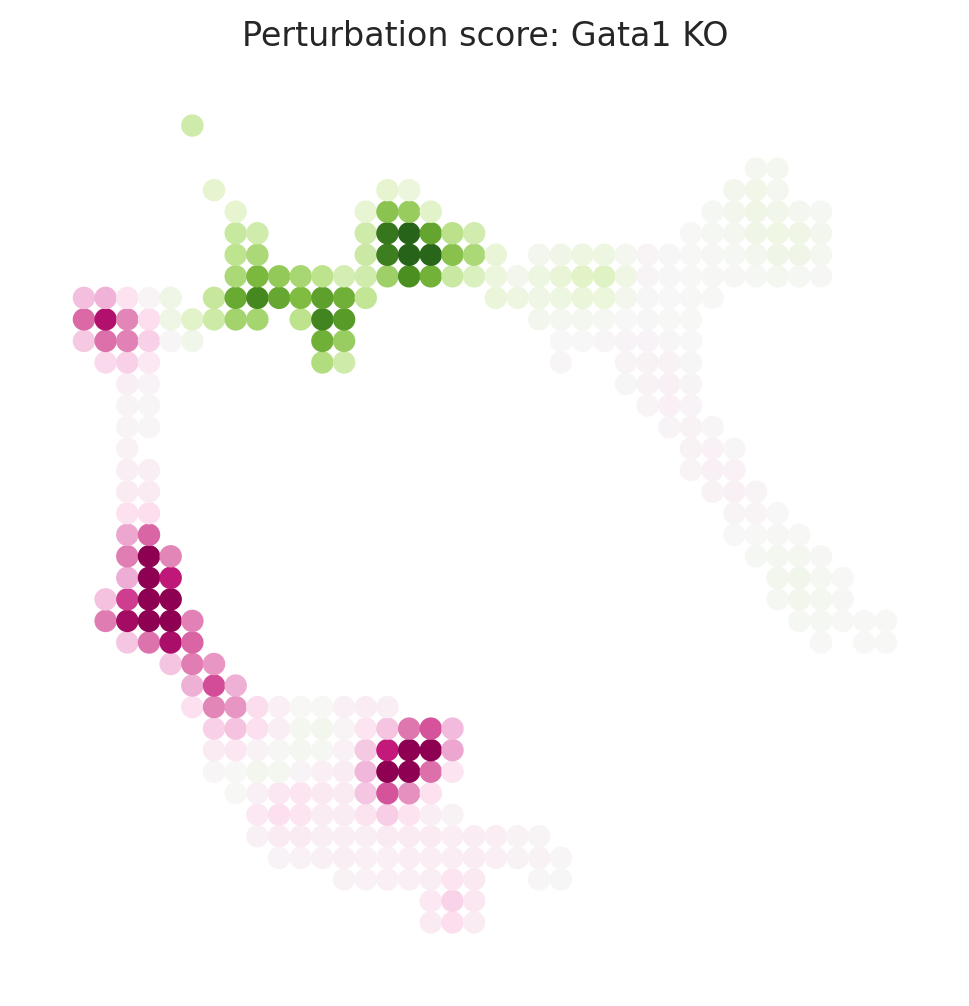

In [24]:
# visualize perturbation scores (i.e. inner products results)
vm = 0.02

fig, ax = plt.subplots(figsize=[6,6])
dev.plot_inner_product_on_grid(vm=vm, s=50, ax=ax)
ax.set_title(f'Perturbation score: {goi} KO')

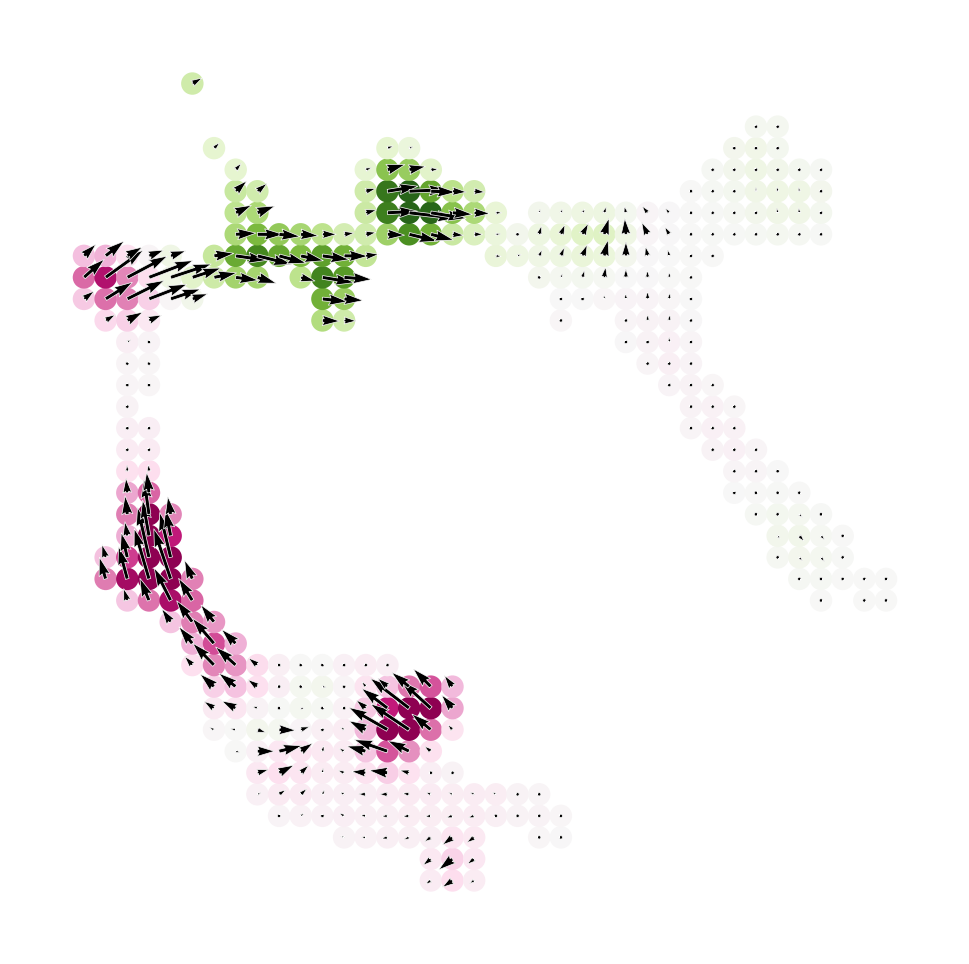

In [25]:
# plot perturbation scores and simulation vector field superimposed
fig, ax = plt.subplots(figsize=[6,6])
dev.plot_inner_product_on_grid(vm=vm, s=50, ax=ax)
dev.plot_simulation_flow_on_grid(scale=scale_simulation, show_background=False, ax=ax)

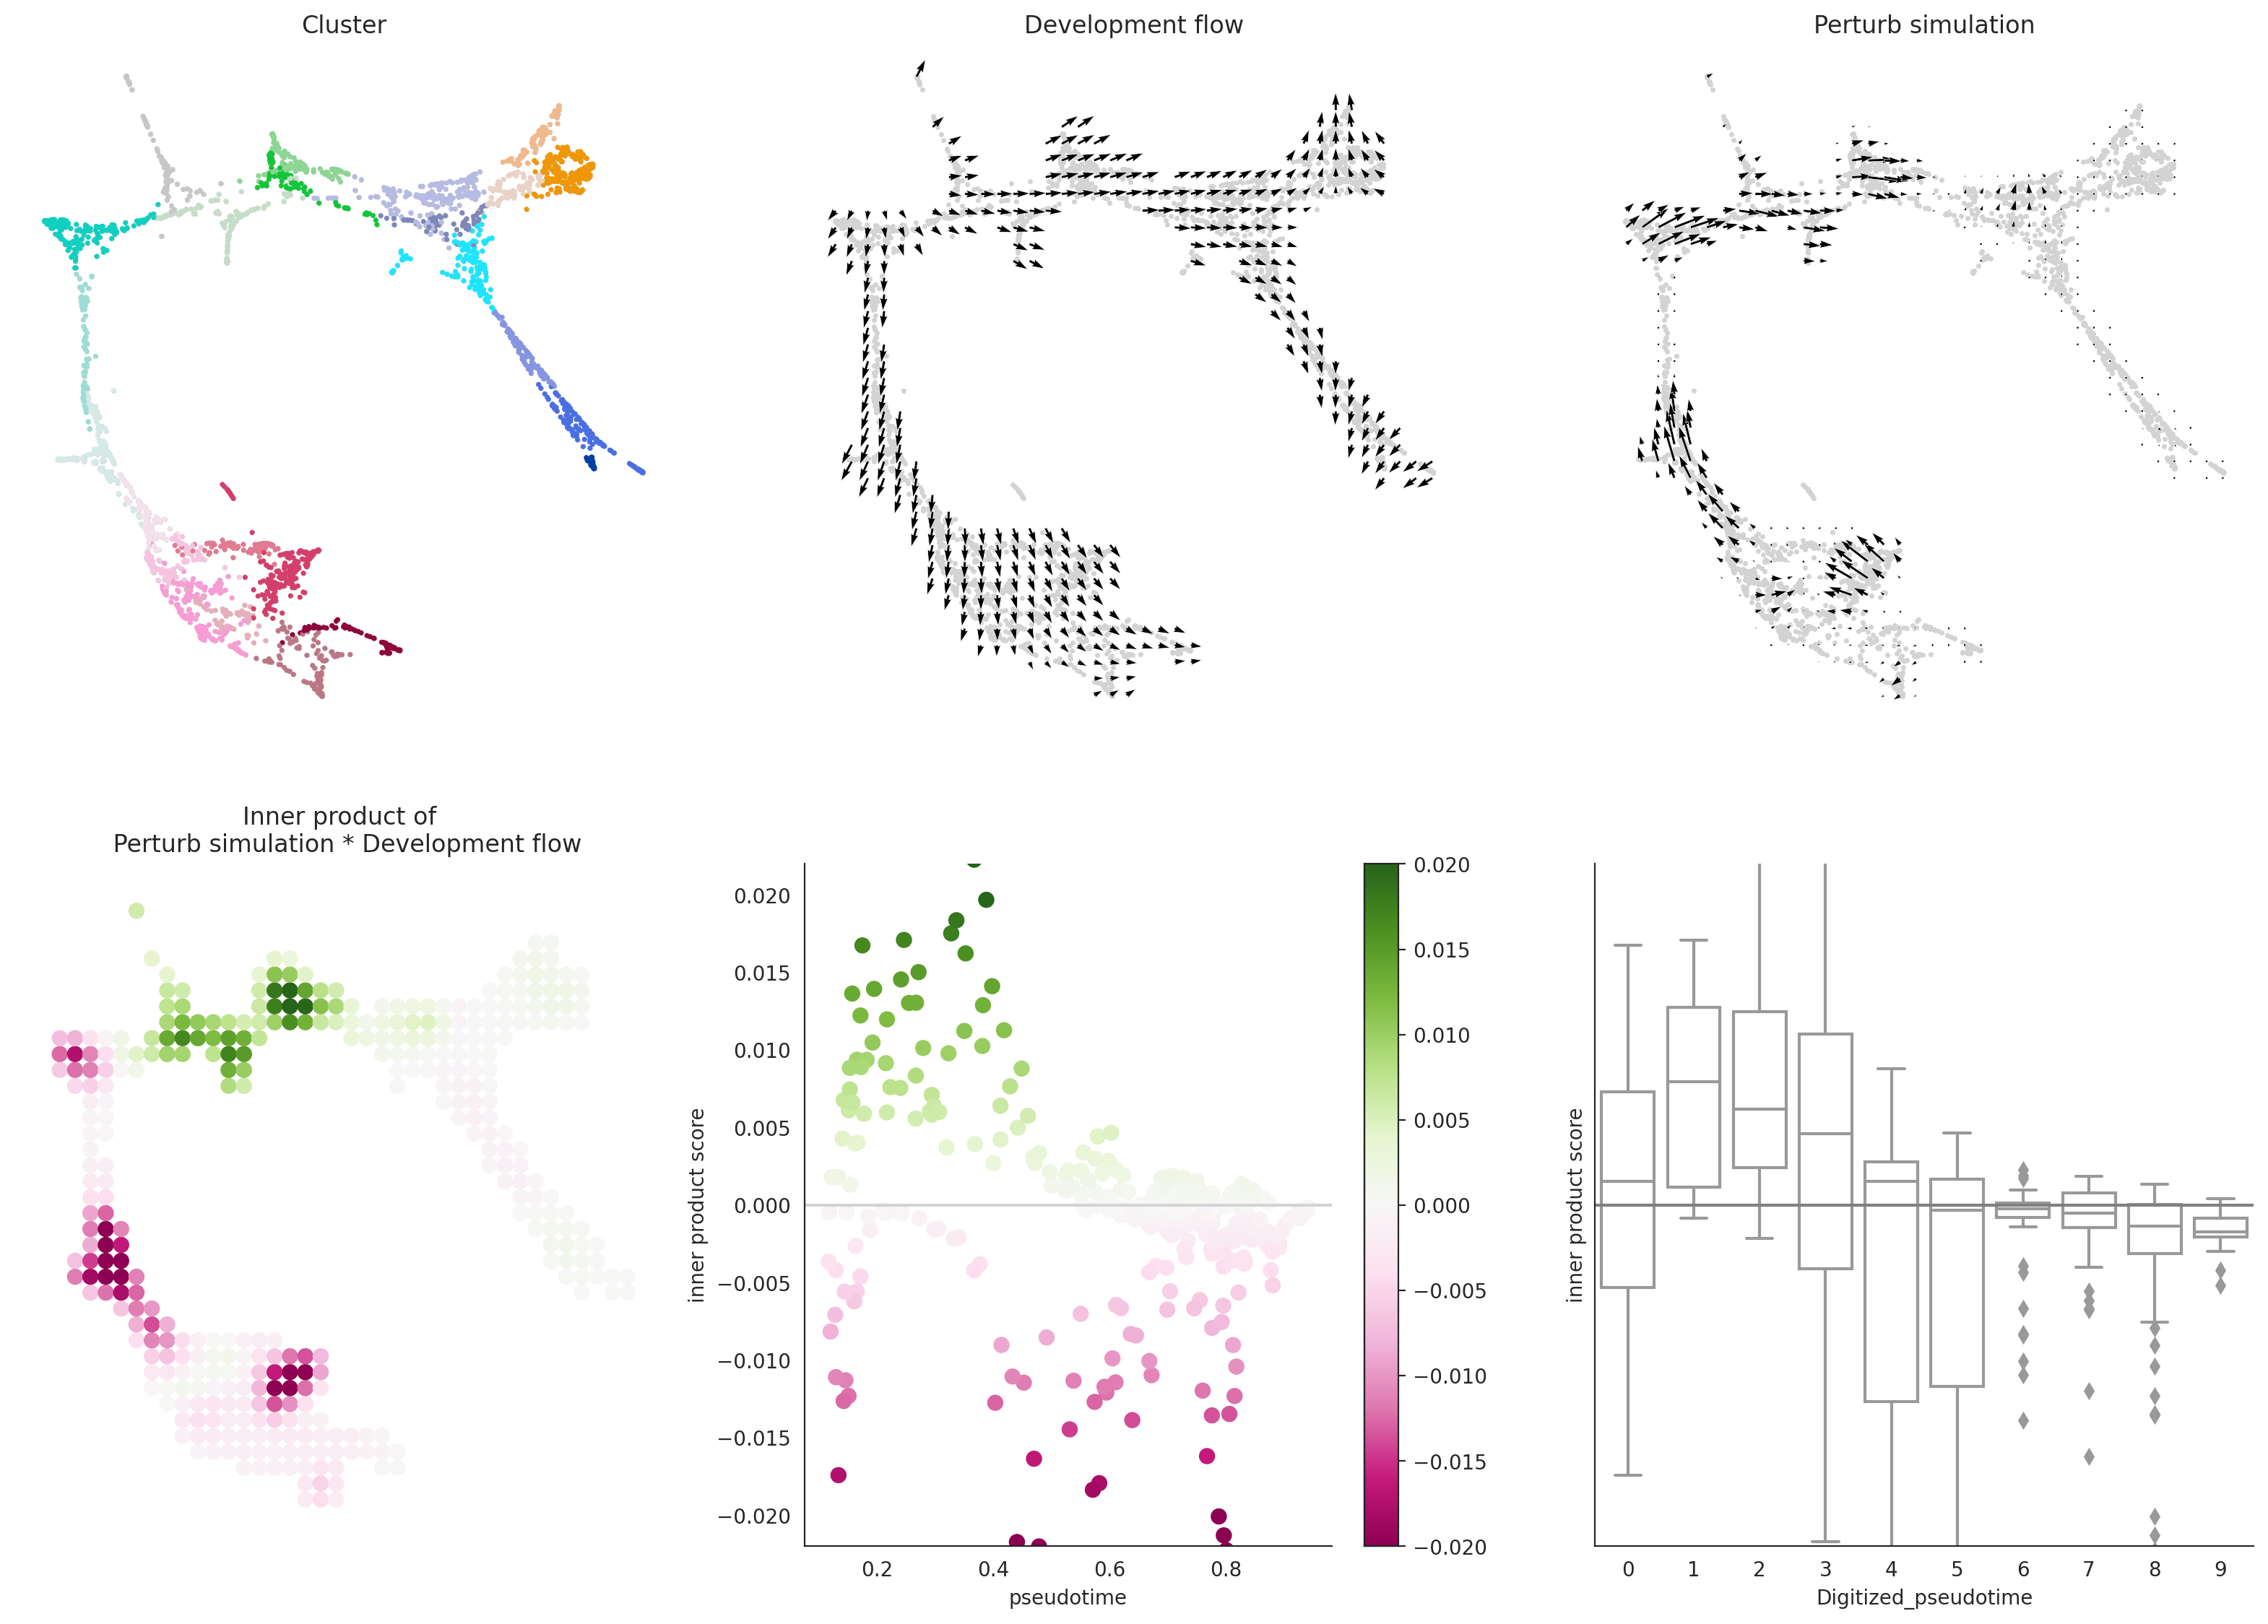

In [26]:
# use built-in visualization scheme
dev.visualize_development_module_layout_0(s=5,scale_for_simulation=scale_simulation,s_grid=50, scale_for_pseudotime=40, vm=vm)

Comparing the simulation outcome to previous well-established literature results shows and agreement with known role of Gata1 in myeloid differentiation: this gene is indeed a promoter of ME lineage differentiation, thus its knockout results in strong negative scores on this differentiation branch

## 5.3&nbsp;Single lineage analysis

We focus on a specific part of the developmental trajectory to interpret the results in depth and see how CellOracle answers biological questions. In particular, we choose the above mentioned ME lineage.

In [27]:
# choose the lineage
links.links_dict.keys()

dict_keys(['Ery_0', 'Ery_1', 'Ery_2', 'Ery_3', 'Ery_4', 'Ery_5', 'Ery_6', 'Ery_7', 'Ery_8', 'Ery_9', 'GMP_0', 'GMP_1', 'GMP_2', 'GMPl_0', 'GMPl_1', 'Gran_0', 'Gran_1', 'Gran_2', 'Gran_3', 'MEP_0', 'Mk_0', 'Mo_0', 'Mo_1', 'Mo_2'])

In [28]:
lineage = ['Ery_0', 'Ery_1', 'Ery_2', 'Ery_3', 'Ery_4', 'Ery_5', 'Ery_6', 'Ery_7', 'Ery_8', 'Ery_9','MEP_0', 'Mk_0']
cell_idx= np.where(oracle.adata.obs['louvain_annot'].isin(lineage))[0]
cell_idx

array([   0,    2,    4, ..., 2666, 2668, 2670])

In [29]:
dev = Oracle_development_module()

dev.load_differentiation_reference_data(gradient_object=gradient)

dev.load_perturb_simulation_data(oracle_object=oracle, cell_idx_use=cell_idx, name='Lineage_?')

dev.calculate_inner_product()
dev.calculate_digitized_ip(n_bins=10)

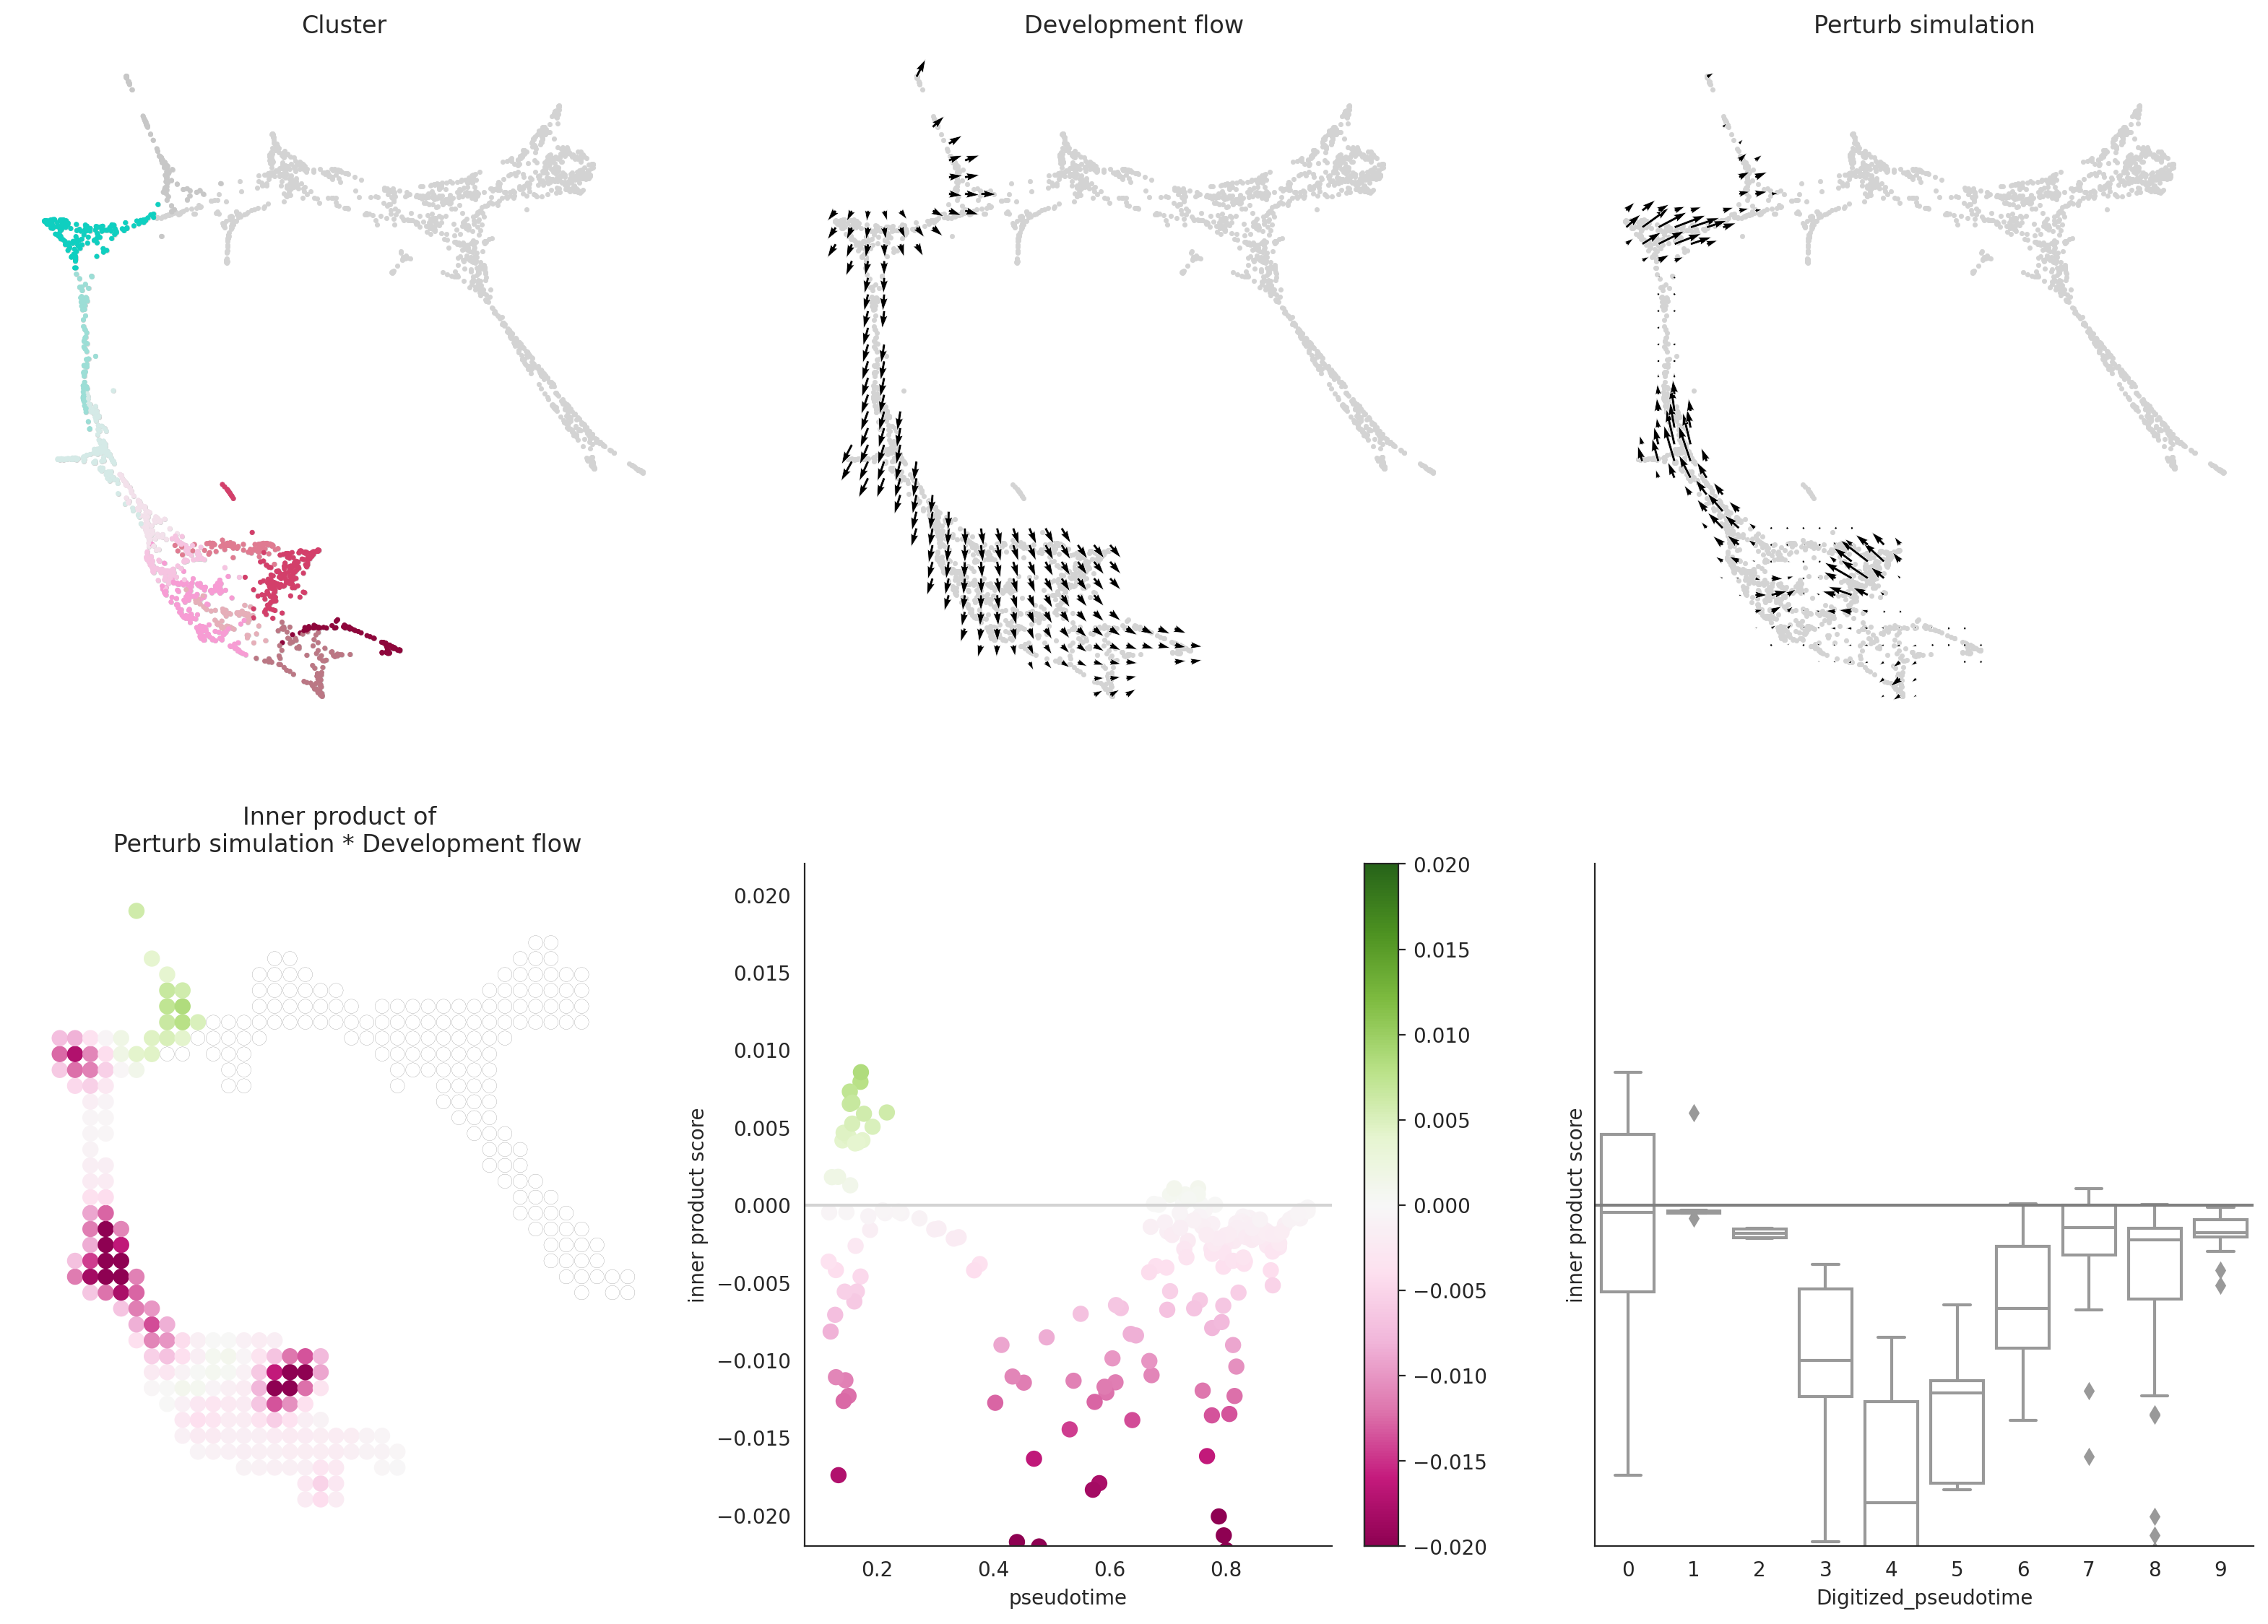

In [30]:
dev.visualize_development_module_layout_0(s=5,scale_for_simulation=scale_simulation,s_grid=50, scale_for_pseudotime=40, vm=vm)

# 6.&nbsp;Results

Using CellOracle algorithm, we were able to demonstrate how single-cell wild-type unperturbated data can be used to simulate perturbations in TFs. Furthermore, the outcomes and even the various steps of this algorithm are easy to interpret, making it possible to investigate cell-identity regulation in the context of dynamic biological processes such as differentiation. More specifically, we were able to simulate the effects of Gata1 KO on the myeloid differentiation, recovering its well-known role in promoting ME lineage differentiation; its knockout yielded indeed very low perturbatiuon scores in this differentiation branch.

## 6.1&nbsp;Further considerations

We have reproduced here only one of the many possible simulations, mainly aiming to demonstrate how CellOracle can be used, but a major biological potential of the algorithm is that it could predict previously unknown roles of transcription factors and thus unknown phenotypes. The article presents, for example, how simulation of *noto* loss of function in the zebrafish development leads to expansion of the prechordal plate, a result that was not reported before and that was also subsequently experimentally validated. It is exactly in this regard that I think CellOracle offers its strongest contribution: in potentially suggesting experimental directions. One also needs to acknowledge the power of this tool in situations where the experimental approach is not possible, such as human development.
One consideration that needs to be exposed about the algorithm is that, for some cases, the simulation results depend on the method used for dimensionality reduction, making the algorithm less transparent to interpretation, however, general directions on how to choose an appropriate embedding are offered in the article.